In [ ]:
def get_database():
    from pymongo import MongoClient
    import pymongo

    # Provide the mongodb atlas url to connect python to mongodb using pymongo
    CONNECTION_STRING = "localhost:27017"

    # Create a connection using MongoClient. You can import MongoClient or use pymongo.MongoClient
    from pymongo import MongoClient
    client = MongoClient(CONNECTION_STRING)

    # Create the database for our example (we will use the same database throughout the tutorial
    return client['stocks']

# Get the database
stocks = get_database()

In [ ]:
import datetime
from dateutil.relativedelta import *

now = datetime.datetime.now()
up_to_date = True


records = stocks["records-a"]

if datetime.datetime.today().weekday() > 5:
  now = now - datetime.timedelta(days=now.weekday()) + datetime.timedelta(days=4, weeks=0)
if records.find_one({})["0001-HK"][-1]["Date"].date() < now.date():
  up_to_date = False

print(records.find_one({})["0001-HK"][-1]["Date"].date(), now.date())

In [ ]:
up_to_date = False

In [ ]:
# import pandas as pd
# import yfinance as yf
# import datetime
# import talib
# import numpy as np
# import datetime

# records = stocks["records-a"]
# records.drop({})
# if up_to_date == False:
#   for a in range(1, 10):
#     print(a)
#     df = yf.download("%04d.hk" % a, start="2021-01-01", end=now.date()+ datetime.timedelta(days=1))
#     if not df.empty:
#       df.reset_index(inplace=True)
#       df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
#       df["MA10"] = talib.SMA(df.Close, 10)
#       df["MA20"] = talib.SMA(df.Close, 20)
#       df["MA10"] = talib.SMA(df.Close, 50)
#       df["MA200"] = talib.SMA(df.Close, 200)

#       records.insert_one({"%04d-HK" % a: df.to_dict(orient='records')})

In [ ]:
import yfinance as yf
stock_list = ["%04d.HK" % i for i in range(1,16)]

df = yf.download(stock_list, period="1y", group_by = 'ticker')

In [ ]:
import pandas as pd
import numpy as np
import datetime
import talib
data_list = []
if up_to_date == False:
  for stock in stock_list:
    stock_df = df[stock]
    if not np.isnan(stock_df.Close[1]):
      print(stock)
      df.loc[:, (stock, "MA10")] = talib.SMA(stock_df["Close"], 10)
      df.loc[:, (stock, "MA20")] = talib.SMA(stock_df["Close"], 20)
      df.loc[:, (stock, "MA50")] = talib.SMA(stock_df["Close"], 50)
      df.loc[:, (stock, "MA200")] = talib.SMA(stock_df["Close"], 200)
      formatted_stock = stock.replace(".", "-")
      data_list.append(  {f"{formatted_stock}": df.loc[:, stock].reset_index().to_dict('records')})

In [ ]:

# if up_to_date == False:
records = stocks["records-a"]
records.drop({})

records.insert_many(data_list)

In [ ]:
import datetime
# SELECT A
records = stocks["records-a"]

a_ticker_records = records.find({"0005-HK": {"$exists": True}}, {
    "0005-HK": {
      "$filter": {
        "input": "$0005-HK",
        "as": "index",
        "cond": {"$and": [ { "$gt": ["$$index.Date", datetime.datetime(2022, 2, 10, 0, 0)] }]}
      }
    }
})

print(a_ticker_records[0]["0005-HK"])

a_ticker_records2 = records.aggregate([{ "$project": {
    "0005-HK": {
      "$filter": {
        "input": "$0005-HK",
        "as": "index",
        "cond": {"$and": [ { "$gt": ["$$index.Date", datetime.datetime(2022, 2, 10, 0, 0)] }]}
      }
    }
}}])

result = [x for x in a_ticker_records2 if x["0005-HK"] is not None]
print(result[0]["0005-HK"])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import talib
import yfinance as yf
import pandas as pd

ticker = yf.download("0005.hk", period="1y")

df = pd.DataFrame(ticker)
data = df.reset_index()


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

plt.plot(np.array(data.Date), np.array(data.Close), marker=".")
plt.plot(np.array(data.Date), np.array(talib.SMA(data.Close, 10)), marker="*")
plt.plot(np.array(data.Date), np.array(talib.SMA(data.Close, 20)), marker="*")
plt.plot(np.array(data.Date), np.array(talib.SMA(data.Close, 50)), marker="x")
plt.plot(np.array(data.Date), np.array( talib.RSI(np.array(data.Close), timeperiod=14)), marker="x")

plt.show()


In [ ]:
import pandas as pd
records = stocks["records-a"]
stock = input("Ticker: ").upper().replace(".", "-")

dates = records.find_one({f"{stock}.Date": {"$exists": True}}, {"Dates":f"${stock}.Date"})["Dates"]
Close = records.find_one({f"{stock}.Close": {"$exists": True}}, {"Close":f"${stock}.Close"})["Close"]
MA10 = records.find_one({f"{stock}.MA10": {"$exists": True}}, {"MA10":f"${stock}.MA10"})['MA10']
MA20 = records.find_one({f"{stock}.MA20": {"$exists": True}}, {"MA20":f"${stock}.MA20"})['MA20']
MA50 = records.find_one({f"{stock}.MA50": {"$exists": True}}, {"MA50":f"${stock}.MA50"})['MA50']
rsi = talib.RSI(np.array(Close), timeperiod=14)
table = []
profit = 0
# for i in range(19, len(MA20)):
#   if MA10[i-1] < MA20[i-1] and MA10[i] > MA20[i] and MA10[i] < MA50[i] and MA20[i] < MA50[i]:
#     table.append([dates[i], Close[i], "BUY", MA10[i], MA20[i], 0])
#   elif MA10[i-1] < MA10[i] and MA10[i] <= MA20[i]:
#     last_buy = [x for x in table if x[2] == "BUY"]
#     if len(last_buy) > 0:
#       profit += Close[i]-last_buy[-1][1]
#       table.append([dates[i], Close[i], "SELL", MA10[i], MA20[i], Close[i]-last_buy[-1][1]])

# for i in range(19, len(MA20)):
#   if rsi[i] < 30 and (len(table) < 1 or table[-1][2] == "SELL"):
#     table.append([dates[i], Close[i], "BUY", MA10[i], MA20[i], 0])
#   elif rsi[i] > 70 and (len(table) > 0 and table[-1][2] == "BUY"):
#     profit += Close[i]-table[-1][1]
#     table.append([dates[i], Close[i], "SELL", MA10[i], MA20[i], Close[i]-table[-1][1]])
rsi_bool = False
for i in range(19, len(MA20)):
  if rsi[i] < 30:
    rsi_bool = True
  if rsi_bool and MA10[i] > MA20[i] and (len(table) < 1 or table[-1][2] == "SELL"):
    table.append([dates[i], Close[i], "BUY", MA10[i], MA20[i], 0])
  elif rsi[i] > 70 and (len(table) > 0 and table[-1][2] == "BUY"):
    profit += Close[i]-table[-1][1]
    table.append([dates[i], Close[i], "SELL", MA10[i], MA20[i], Close[i]-table[-1][1]])

print(profit)
pd.set_option('display.max_rows', None)
pd.DataFrame(table, columns=["Date", "Value", "Action", "MA(10)", "MA(20)", "Profit"])

In [3]:
import talib
import yfinance as yf
import pandas as pd
from itertools import compress

df = yf.download("0005.hk", period="3mo", group_by = 'ticker')
df.reset_index(inplace=True)

candle_names = talib.get_function_groups()['Pattern Recognition']

op = df['Open']
hi = df['High']
lo = df['Low']
cl = df['Close']


for candle in candle_names:
  # below is same as;
  df[candle] = getattr(talib, candle)(op, hi, lo, cl)

[*********************100%***********************]  1 of 1 completed


In [4]:
import numpy as np 
df['candlestick_pattern'] = np.nan
df['candlestick_match_count'] = np.nan

for index, row in df.iterrows():
    # no pattern found
    if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
        df.loc[index,'candlestick_pattern'] = "NO_PATTERN"
        df.loc[index, 'candlestick_match_count'] = 0
    
    # single pattern found
    elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:
        if any(row[candle_names].values > 0): # bull pattern
            pattern = list(compress(
                row[candle_names].keys(),
                row[candle_names].values != 0
            ))[0] + '_Bull'
        else: # bear pattern
            pattern = list(compress(
                row[candle_names].keys(),
                row[candle_names].values != 0
            ))[0] + '_Bear'
        df.loc[index, 'candlestick_pattern'] = pattern
        df.loc[index, 'candlestick_match_count'] = 1
    # multiple patterns found
    else:
        patterns = list(compress(
            row[candle_names].keys(),
            row[candle_names].values != 0
        ))
        container = []
        for pattern in patterns:
            if row[pattern] > 0:
                container.append(pattern + '_Bull')
            else:
                container.append(pattern + '_Bear')
        if len(container):
            df.loc[index, 'candlestick_pattern'] = container[0]
            df.loc[index, 'candlestick_match_count'] = len(container)
df.drop(candle_names, axis=1, inplace=True)


In [5]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,candlestick_pattern,candlestick_match_count
0,2021-12-06,44.500000,44.950001,44.250000,44.849998,44.849998,21997237,NO_PATTERN,0.0
1,2021-12-07,44.799999,45.750000,44.400002,45.650002,45.650002,15839694,NO_PATTERN,0.0
2,2021-12-08,45.950001,45.950001,45.099998,45.500000,45.500000,8590654,NO_PATTERN,0.0
3,2021-12-09,45.450001,45.900002,45.150002,45.299999,45.299999,6908033,NO_PATTERN,0.0
4,2021-12-10,45.099998,45.400002,44.950001,45.200001,45.200001,6090109,NO_PATTERN,0.0
...,...,...,...,...,...,...,...,...,...
56,2022-02-28,55.700001,55.700001,53.799999,54.099998,54.099998,37535471,CDLBELTHOLD_Bear,2.0
57,2022-03-01,54.049999,54.150002,53.200001,54.000000,54.000000,16963545,CDL3OUTSIDE_Bear,9.0
58,2022-03-02,52.099998,52.299999,50.849998,51.200001,51.200001,45247755,NO_PATTERN,0.0
59,2022-03-03,52.599998,53.400002,52.049999,53.299999,53.299999,29710818,NO_PATTERN,0.0


[-10.   0.  10.  20.  30.  40.  50.  60.  70.] [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


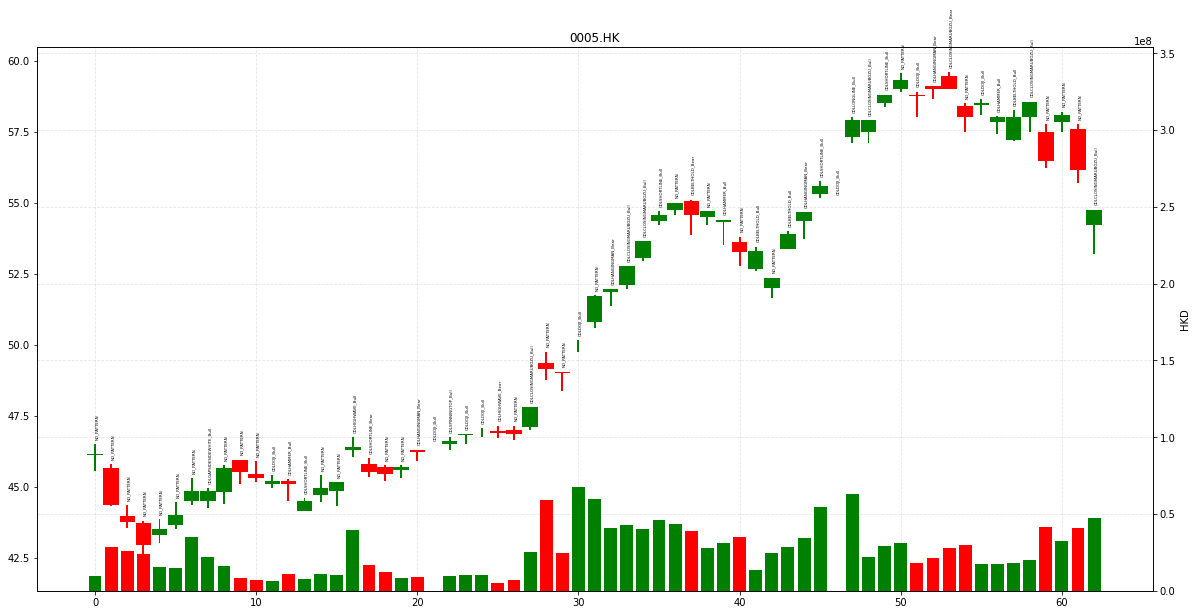

In [34]:
import matplotlib.pyplot as plt

bar_width = 0.12
width, width2 = 8*bar_width, bar_width
up_color, dn_color = 'green', 'red'

fig, ax = plt.subplots(figsize=(20,10))

up = df[df.Close >= df.Open]
dn = df[df.Close < df.Open]


# plot up prices
ax.bar(up.index, up.Close-up.Open, width, bottom=up.Open, color=up_color)
ax.bar(up.index, up.High-up.Close, width2, bottom=up.Close, color=up_color)
ax.bar(up.index, up.Low-up.Open, width2, bottom=up.Open, color=up_color)

# plot down prices
ax.bar(dn.index, dn.Close-dn.Open, width, bottom=dn.Open, color=dn_color)
ax.bar(dn.index, dn.High-dn.Open, width2, bottom=dn.Open, color=dn_color)
ax.bar(dn.index, dn.Low-dn.Close, width2, bottom=dn.Close, color=dn_color)

# add labels
for index, row in df.iterrows():
    ax.annotate(row['candlestick_pattern'], (index, row['High']+0.2), rotation=90, fontsize=4)

# volume
ax2 = ax.twinx()
ax2.bar(up.index, up.Volume, color=up_color)
ax2.bar(dn.index, dn.Volume, color=dn_color)
ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0, ymax*5)
ax2.set_ylabel('Volume')

# grid
ax.xaxis.grid(color='black', linestyle='dashed', which='both', alpha=0.1)
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='black', linestyle='dashed', which='both', alpha=0.1)

# rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('0005.HK')
plt.xlabel('Days')
plt.ylabel('HKD')

plt.show()